In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import BLASSO_SA
import create_sample_data
sns.set_style("whitegrid")

# create artificial data
(see create_sample_data.py)

In [2]:
create_sample_data.main(seed = 1425, n = 1000, m = 30, num_nonzero=15)

# run gibbs sampler + annealing
For having a comparison, we first run the gibbs sampler for a long time.
Then the cooling starts, until the system reached it's final temperature, where we fix the temperature and continue sampling a bit, for getting the annealed estimate.

In [3]:
data = np.load("art_data.npy").item()
X = data["X"]
Y = data["Y"]
betas_true = data["betas"]
LAMBDA = 300
BURNIN = 1000
NITER = 2000
NITER_cd = 100
T_0 = 1
T_n = 0.001

Y_ = Y - np.mean(Y)
BL = BLASSO_SA.BLASSO_SA(X=X, Y=Y_, LAMBDA=LAMBDA, BURNIN=BURNIN,
                         NITER=NITER, NITER_cd=NITER_cd, T_0=T_0, T_n=T_n)
BL.run()

# Trace Plots
We can nicely see the burn in at the first few initial samples and the cool down starting at 1000 iterations.

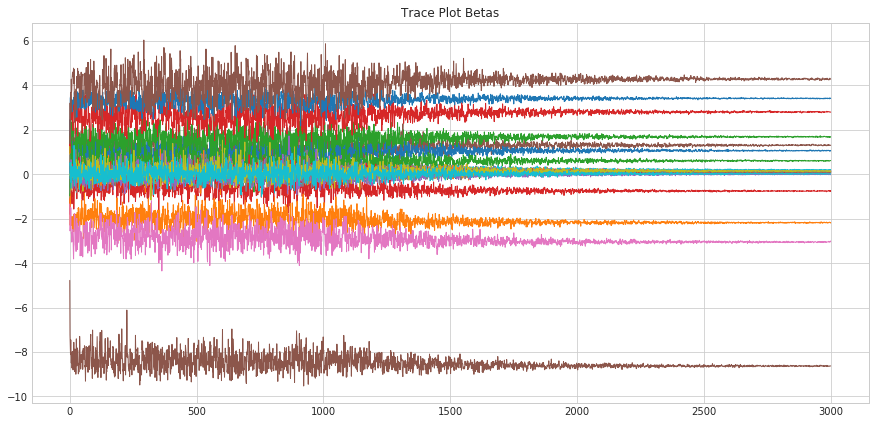

In [8]:
plt.figure(figsize=(15,7))
plt.plot(BL.B_list, linewidth=1)
plt.title("Trace Plot Betas")
plt.show()

# Comparison with True Parameters
Estimate from the Annealing vs the true parameters used. While the estimates are close, it's noticeable that the results are not really sparse, i.e. they never reach 0 without any additional thresholding.

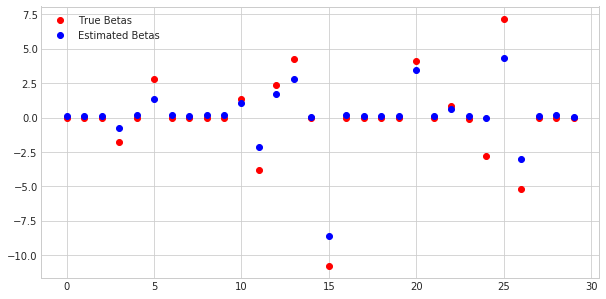

In [5]:
plt.figure(figsize=(10,5))
plt.plot(betas_true, 'o',  label="True Betas", color='r')
plt.plot(BL.beta, 'o', label="Estimated Betas", color='b')
plt.legend()
plt.show()

# Boxplots of marginals: Gibbs without cooling vs. final cooled down
Here we can see it more closely. While the variance decreases as expected, the credible intervals don't cover the 0 anymore.

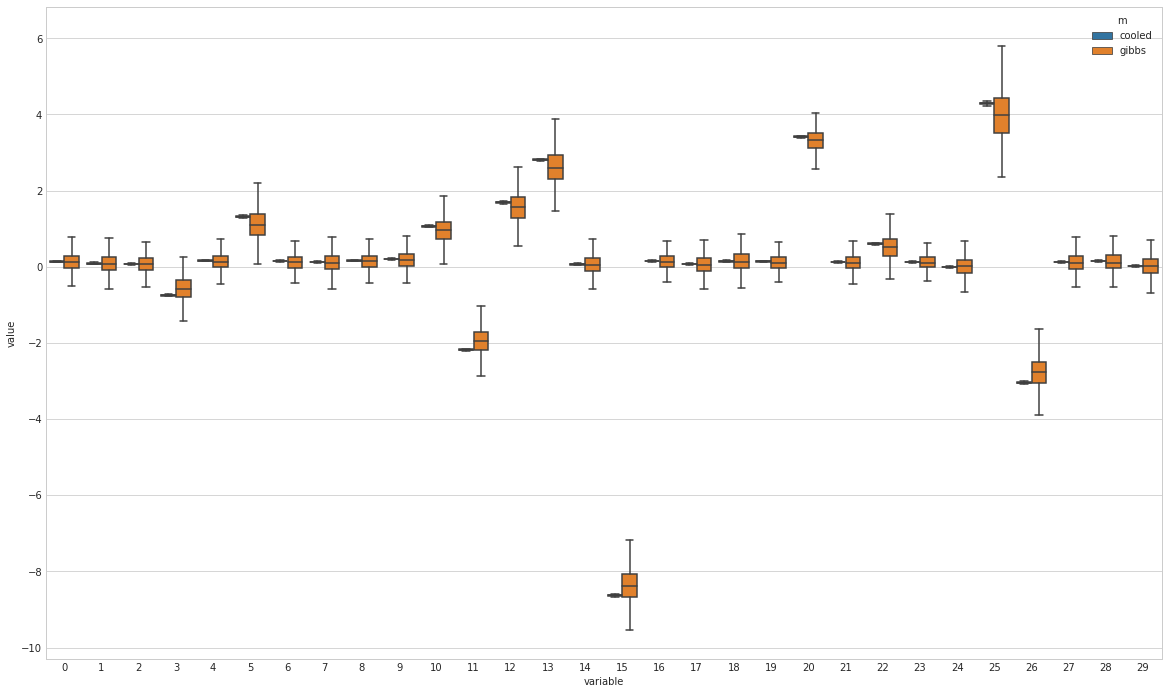

In [6]:

# plt.boxplot(BL.B_list)
# plt.show()
plt.figure(figsize=(20,12))
df_cooled = pd.DataFrame(BL.B_list[-NITER_cd:, :])
df_cooled["m"] = "cooled"
df_gibbs = pd.DataFrame(BL.B_list[:BURNIN, :])
df_gibbs["m"] = "gibbs"
df_joined = pd.concat([df_cooled, df_gibbs], ignore_index=True)
df_l = pd.melt(df_joined, id_vars='m')
sns.boxplot(data=df_l, x='variable', y='value', hue='m', fliersize=0)
plt.show()

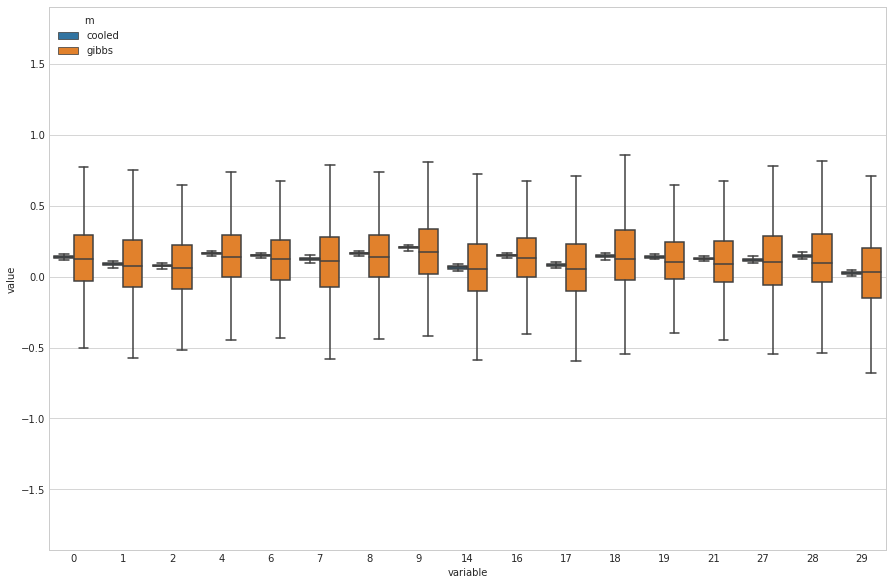

In [7]:
plt.figure(figsize=(15,10))
df_z = df_l.loc[df_l['variable'].isin(np.where(betas_true==0)[0])]
sns.boxplot(data=df_z, x='variable', y='value', hue='m', fliersize=0)
plt.show()